In [1]:
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os

import threading

In [32]:
def plot_cwnd_vs_time():
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    cwndvstime = {}
    
    with open("./cwnd_trace_file.txt", "r") as f:
        lines = f.readlines()

    for line in lines:
        split_line = line.split()
        cwndvstime[float(split_line[0])] = float(split_line[1]);

        
    plt.plot(cwndvstime.keys(), cwndvstime.values())
    plt.xlabel("time")
    plt.ylabel("cwnd")
    plt.title("Congestion windows size vs time ")
    f.close()
    
    
    
    

In [33]:
def clean(flavor = "default" , time = 200 , queueL = 5, noOfSource = 4, total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTT = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTT));

In [38]:
def main(flavour = "TcpBic" , time = 200 ,access_bandwidth = 120, bottleneck_bandwidth = 100, bottleneck_delay = 1 , RTT = 10, packetSize = 1458, queueL = 5, noOfSource = 2, packetPerSource = 10000000, sourceRate = 5):
    
    if os.path.exists("./cwnd_trace_file.txt"):
        os.system("rm ./cwnd_trace_file.txt")
        
    RTTperlink = RTT/4
    cmd = f"./waf --run \"scratch/tcp_ftp_n --nSources={noOfSource} --flavour={flavour} --bottleneckBandwidth={bottleneck_bandwidth}Mbps --bottleneckDelay={bottleneck_delay}ms --accessBandwidth={access_bandwidth}Mbps --accessDelay={RTTperlink}ms --queueSize={queueL}p --pktSize={packetSize} --simDuration={time} --nPackets={packetPerSource} --sourceRate={sourceRate}\""
    print(cmd)
    os.system(cmd)
    plot_cwnd_vs_time()
    #clean(flavor = flavor, time = time, queueL = queueL, noOfSource = noOfSource, total_input_bandwidth = total_input_bandwidth, bottleneck_bandwidth= bottleneck_bandwidth, RTT = RTT, recvWindow = recvWindow)   


./waf --run "scratch/tcp_n --nSources=1 --flavour=TcpBic --bottleneckBandwidth=1Mbps --bottleneckDelay=1ms --accessBandwidth=1Mbps --accessDelay=2.0ms --queueSize=500p --pktSize=1500 --simDuration=100 --nPackets=1000 --sourceRate=1"
Waf: Entering directory `/mnt/Store/Project-summer/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/mnt/Store/Project-summer/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (4.650s)


AnimationInterface WARNING:Node:0 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:1 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:2 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:3 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:0 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:1 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:2 Does not have a mobility model. Use SetConstantPosition if it is stationary
AnimationInterface WARNING:Node:3 Does not have a mobility model. Use SetConstantPosition if it is stationary


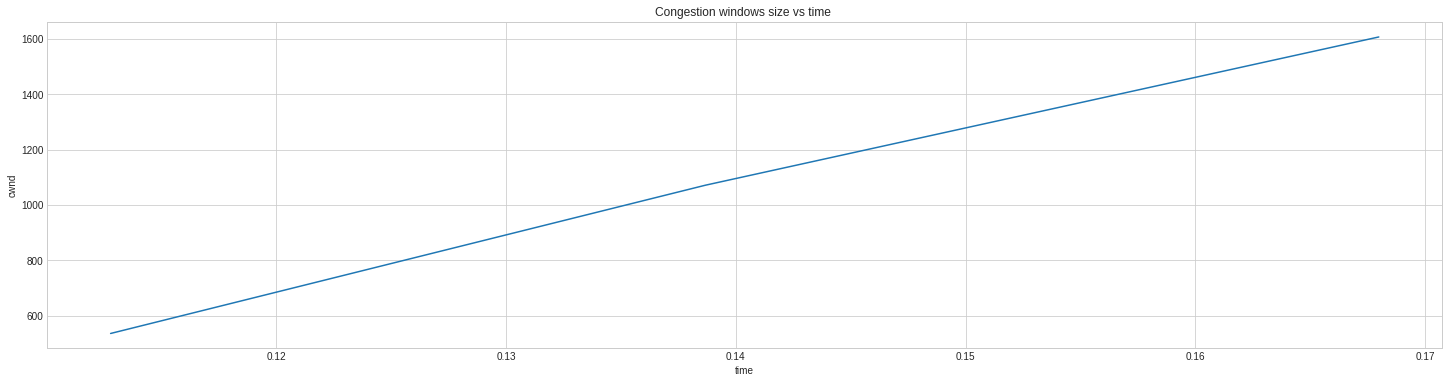

In [45]:
main(flavour = "TcpBic", 
     time = 100, 
     noOfSource=1, 
     access_bandwidth = 1, 
     bottleneck_bandwidth = 1, 
     bottleneck_delay = 1 , 
     RTT = 8, 
     packetSize = 1500, 
     queueL = 500, 
     packetPerSource = 1000, 
     sourceRate=1)

In [ ]:
# # Running multiple simulations

# RTTs = [10, 100, 200]
# sources = [1, 40]

# threads = []

# for rtt in RTTs:
#     for s in sources:
#         threads.append(threading.Thread(target=main, args=("bbr", 20, 2084, s, 120, 100, rtt, 10000)))
        
# for thread in threads:
#     thread.start()

# for thread in threads:
#     thread.join()

In [ ]:
#main(flavor = "bbr", time = 20, queueL = 2084, noOfSource = 3, total_input_bandwidth = 120, bottleneck_bandwidth= 120, RTT = 10, recvWindow = 10000)